## Importing data

In [167]:
# import packages
import GEOparse
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import anndata
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import scanpy.external as sce

In [168]:
# read in genes by cells raw count data
adata_ctrl = sc.read_text('/Users/Joyce/Documents/COLUMBIA/COLUMBIA MS/BMEN4480/Final Project/GSE115571_RAW/GSM3182555_CTRL.txt', 
                          first_column_names = True)
adata_lps = sc.read_text('/Users/Joyce/Documents/COLUMBIA/COLUMBIA MS/BMEN4480/Final Project/GSE115571_RAW/GSM3182556_LPS.txt', 
                          first_column_names = True)

In [169]:
# transpose to cells x genes
adata_ctrl = adata_ctrl.transpose()
adata_lps = adata_lps.transpose()

In [170]:
adata_ctrl.shape

(9999, 16247)

In [171]:
adata_lps.shape

(9999, 16501)

In [172]:
# annotate as ctrl or lps
adata_ctrl.obs['group'] = 'control'
adata_lps.obs['group'] = 'lps'

In [173]:
# concatenate
adata = adata_ctrl.concatenate(adata_lps)

In [174]:
adata

AnnData object with n_obs × n_vars = 19998 × 14426
    obs: 'group', 'batch'

## QC Filtering

In [175]:
# filter out cells with less than 1000 counts & genes not expressed in at least 1 cell
sc.pp.filter_cells(adata, min_counts = 1000)
sc.pp.filter_genes(adata, min_cells = 1)

In [176]:
adata.shape

(1246, 13963)

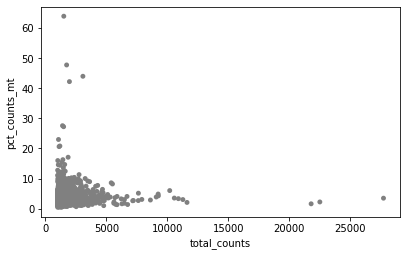

In [178]:
# remove cells with too many mitochondrial genes expressed
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [179]:
# convert to dataframe
df = adata.to_df()

In [180]:
df.head()

,0610007P14Rik,0610009B22Rik,0610009D07Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610030E20Rik,...,n-R5s156,n-R5s193,n-R5s2,n-R5s202,n-R5s205,n-R5s33,n-R5s40,n-R5s47,n-R5s71,n-R5s88
CCCCAAACACCG-0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
TTAACGGTCTGT-0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTCAAGATACAG-0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTCTTAATATN-0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TGATGTTTGACT-0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalization

In [181]:
# scale to CPM
sc.pp.normalize_total(adata, target_sum=1e6)

/Users/Joyce/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Dimensionality reduction and visualization

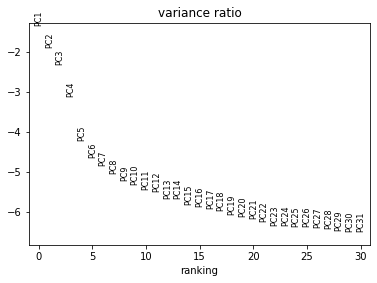

In [182]:
# PCA
sc.pp.pca(adata)

# PCA variance ratio
sc.pl.pca_variance_ratio(adata, n_pcs = 30, log = True)

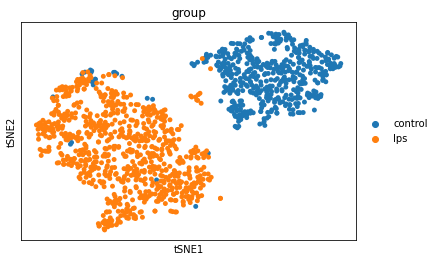

In [184]:
# tSNE on top 11 PCs
sc.tl.tsne(adata, 11)

# 2D tSNE embedding
sc.pl.tsne(adata, color = 'group')

In [140]:
adata

AnnData object with n_obs × n_vars = 1246 × 13963
    obs: 'group', 'batch', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'tsne', 'group_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

## Clustering

... storing 'kmeans2' as categorical
... storing 'kmeans3' as categorical


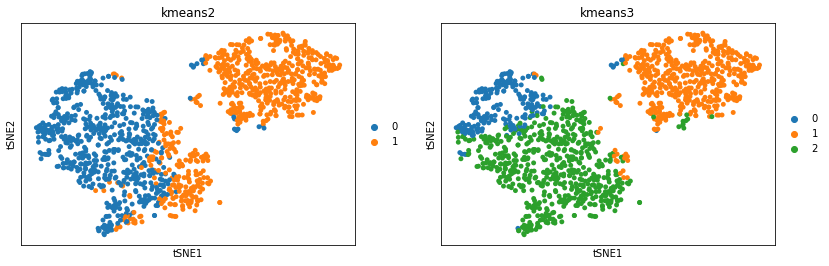

In [185]:
# extract pca coordinates
X_pca = adata.obsm['X_pca']

# kmeans for k = 2,3
for i in range(2,4):
    kmeans = KMeans(n_clusters = i, random_state = 0).fit(X_pca)
    adata.obs[f'kmeans{i}'] = kmeans.labels_.astype(str)
    
# tSNE projection colored by cluster IDs
sc.pl.tsne(adata, color = ['kmeans2', 'kmeans3'])

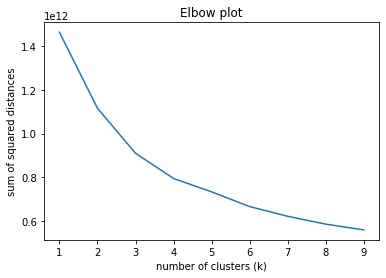

In [186]:
# elbow method to check optimal k
ssd = []
k = range(1,10)
for i in k:
    kmeans = KMeans(n_clusters = i).fit(X_pca)
    ssd.append(kmeans.inertia_) # inertia = sum of square distances of samples to closest cluster center
plt.plot(k, ssd)
plt.xlabel('number of clusters (k)') 
plt.ylabel('sum of squared distances') 
plt.title('Elbow plot')
plt.show()

In [196]:
# nearest neighbors
sc.pp.neighbors(adata, n_neighbors = 15, metric = 'manhattan')

# leiden clustering
sc.tl.leiden(adata, resolution = 0.3)

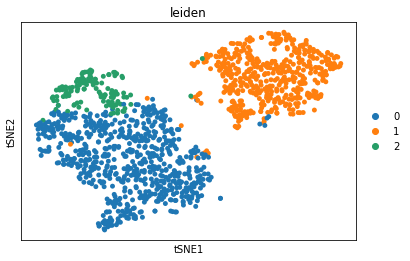

In [197]:
sc.pl.tsne(
    adata, color = 'leiden',
    palette = sc.pl.palettes.vega_20_scanpy
)

## Differential expression analysis

/Users/Joyce/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/Joyce/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Users/Joyce/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/Joyce/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


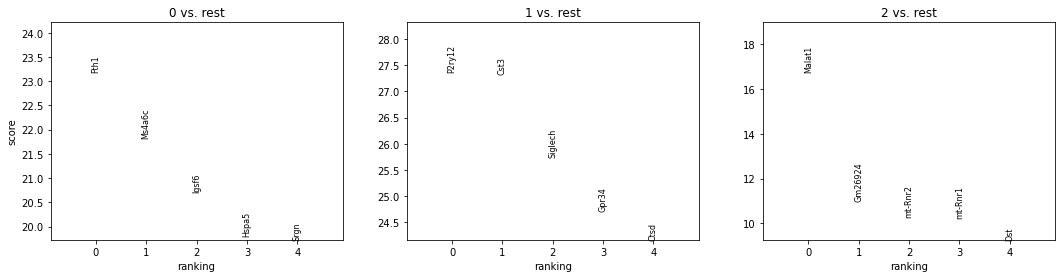

In [198]:
# DEGS
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes = 5, sharey = False, key = "wilcoxon")

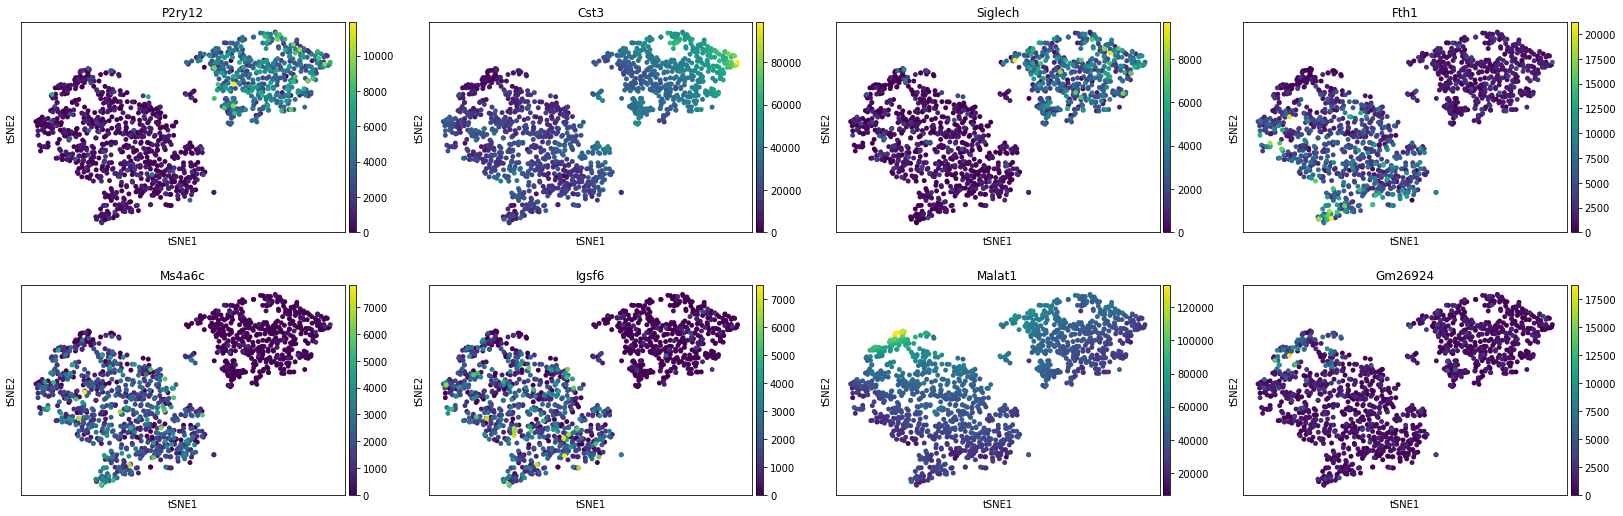

In [202]:
# color embedding with expression of some DEGs
sc.pl.tsne(
    adata, color = ['P2ry12','Cst3','Siglech','Fth1','Ms4a6c','Igsf6','Malat1','Gm26924'],
    palette = sc.pl.palettes.vega_20_scanpy
)

## Trajectory inference/DPT

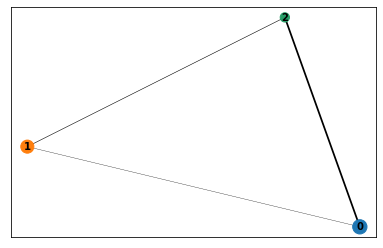

In [200]:
# trajectory inference
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = ['leiden'])

In [204]:
adata_lps2 = adata[adata.obs.group == 'lps', :]

In [205]:
adata_lps2

View of AnnData object with n_obs × n_vars = 761 × 13963
    obs: 'group', 'batch', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'kmeans2', 'kmeans3', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'tsne', 'group_colors', 'kmeans2_colors', 'kmeans3_colors', 'neighbors', 'leiden', 'leiden_colors', 'wilcoxon', 'paga', 'leiden_sizes', 'draw_graph'
    obsm: 'X_pca', 'X_tsne', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

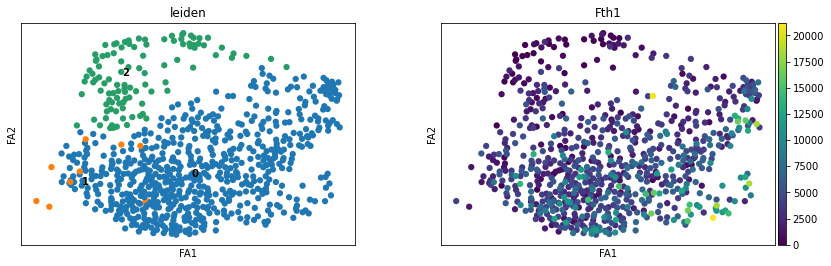

In [208]:
sc.tl.draw_graph(adata_lps2, init_pos = 'paga')
sc.pl.draw_graph(adata_lps2, color = ['leiden', 'Fth1'], legend_loc = 'on data')

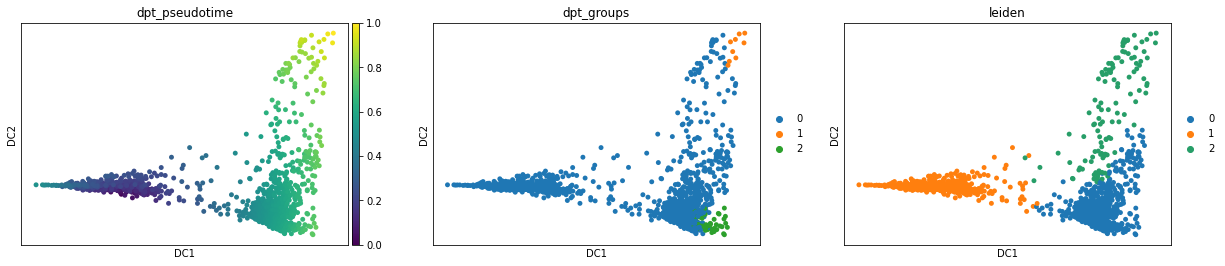

In [220]:
# diffusion pseudotime analysis
adata.uns['iroot'] = np.flatnonzero(adata.obs['group'] == 'control')[0]
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings = 1, n_dcs = 10)
sc.pl.diffmap(adata, color=['dpt_pseudotime', 'dpt_groups','leiden'])